# YOLOv11-Small Model Image Classification
Based on Edje Electronics' YOLO Tutorial:
###### https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models

### Download the COCO dataset
Use the functions defined in `../data/load_coco_dataset.py` to download data for the desired objects for detection to train the model on and process it into the required format for further processing.

In [1]:
import os
import sys
import subprocess
sys.path.append(os.path.abspath(os.path.join('..')))

# Load the dataset and launch the FiftyOne app to visualize it
import data.load_coco_dataset as lcd
classes = ['bottle']
lcd.launch_fiftyone_app(lcd.load_and_parse_coco_dataset(classes=classes))

/home/jacob/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found annotations at '/home/jacob/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-500'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Directory '../data/coco_data' already exists; export will be merged with existing files
 100% |█████████████████| 500/500 [312.3ms elapsed, 0s remaining, 1.6K samples/s]      
Computing embeddings...
 100% |█████████████████| 500/500 [532.9ms elapsed, 0s remaining, 970.7 samples/s]   
Computing uniqueness...
Uniqueness computation complete
Loaded 500 samples from the COCO-2017 dataset         with the following classes: ['bottle']:
Dataset:     coco-2017-train-500
Media type:  image
Num samples: 500
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(

FiftyOne running at: http://localhost:5151/


### Split the dataset
Use the functions defined in `../data/data_splitter.py` to randomly split the given dataset into 80% for training and 20% for validation.

In [2]:
import data.data_splitter as ds
data_dir = '../data/coco_data'
ds.split_data(data_dir)

Number of image files: 500
Number of annotation files: 500
Images moving to train: 400
Images moving to test: 100


### Configure Model Training and Validation
Use the function defined in `../data/data_yaml_generator.py` to create the YAML data file for training and the `yolo detect {train/predict}` function given by Ultralytics for training and validating the YOLOv11 model on the dataset.

In [4]:
# Create a YAML configuration file for YOLO
import data.data_yaml_generator as dyg
yaml_file = '../data/data.yaml'
classes_file = f'{data_dir}-split/classes.txt'
dyg.create_data_yaml(classes_file, yaml_file)

# Train the model using the YAML configuration file and YOLO model
RETRAIN_MODEL = True
if RETRAIN_MODEL or not os.path.exists('yolo11s.pt'):
    subprocess.run([
        "yolo", "detect", "train",
        f"data={yaml_file}",
        "model=yolo11s.pt",
        "epochs=60",
        "imgsz=640"
    ])

Created config file at ../data/data.yaml
New https://pypi.org/project/ultralytics/8.3.127 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.126 🚀 Python-3.12.9 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24077MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train17, nb

train: Scanning /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/data/coco_data-split/train/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 5301.13it/s]
val: Scanning /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/data/coco_data-split/test/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 3522.85it/s]


val: New cache created: /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/data/coco_data-split/test/labels.cache
Plotting labels to runs/detect/train17/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train17
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.96G      1.519      4.674      1.253         56        640: 100%|██████████| 25/25 [00:01<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.77it/s]


                   all        100        277      0.479      0.282      0.276      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.88G      1.677      2.416      1.326        102        640: 100%|██████████| 25/25 [00:01<00:00, 18.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 19.61it/s]
       3/60      4.89G      1.787      2.349      1.557         68        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277     0.0168      0.184     0.0104    0.00463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.89G      1.792      2.219      1.459         56        640: 100%|██████████| 25/25 [00:01<00:00, 18.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 19.95it/s]


                   all        100        277     0.0547      0.108     0.0196    0.00704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.89G      1.844      2.174      1.473         72        640: 100%|██████████| 25/25 [00:01<00:00, 18.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.96it/s]


                   all        100        277   0.000906     0.0975   0.000497   0.000226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.89G       1.91      2.259      1.541        115        640: 100%|██████████| 25/25 [00:01<00:00, 18.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 17.09it/s]
       6/60      4.89G      1.754      1.994      1.351         87        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277    0.00381      0.253    0.00227    0.00114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.89G      1.862      2.144      1.483         89        640: 100%|██████████| 25/25 [00:01<00:00, 18.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 17.48it/s]


                   all        100        277     0.0038      0.292    0.00235    0.00125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.89G      1.868      2.101      1.507         86        640: 100%|██████████| 25/25 [00:01<00:00, 18.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 21.10it/s]
       8/60      4.89G      1.768      1.951      1.313         64        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.341      0.206      0.184     0.0844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.89G      1.837      2.003      1.463         66        640: 100%|██████████| 25/25 [00:01<00:00, 18.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 22.47it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.399      0.256      0.233      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.89G      1.835      2.022      1.464         75        640: 100%|██████████| 25/25 [00:01<00:00, 18.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 21.44it/s]


                   all        100        277      0.298      0.296      0.182      0.079

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.89G      1.756      1.912      1.449         67        640: 100%|██████████| 25/25 [00:01<00:00, 18.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 22.17it/s]
      11/60      4.89G      1.883      1.867       1.46         92        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.423      0.282      0.254      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.89G      1.757      1.878      1.387         62        640: 100%|██████████| 25/25 [00:01<00:00, 18.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 22.17it/s]


                   all        100        277      0.526      0.325      0.358      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      4.89G      1.675      1.766      1.373         70        640: 100%|██████████| 25/25 [00:01<00:00, 18.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.00it/s]
      13/60      4.89G      1.659      1.833      1.223         87        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.456      0.289      0.302      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.89G      1.647      1.696      1.352         42        640: 100%|██████████| 25/25 [00:01<00:00, 18.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.42it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.529      0.325      0.332      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      4.89G      1.673      1.714      1.345         64        640: 100%|██████████| 25/25 [00:01<00:00, 18.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.20it/s]


                   all        100        277      0.516      0.365      0.355      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.89G      1.613      1.696      1.349         75        640: 100%|██████████| 25/25 [00:01<00:00, 18.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 22.98it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.514      0.379      0.369      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      4.89G       1.57      1.662      1.328         96        640: 100%|██████████| 25/25 [00:01<00:00, 18.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.13it/s]


                   all        100        277      0.551       0.39      0.406      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.89G      1.555      1.594      1.296         48        640: 100%|██████████| 25/25 [00:01<00:00, 18.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.10it/s]
      18/60      4.89G      1.648      2.012      1.339         47        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.553      0.367      0.396      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      4.89G      1.597      1.681      1.329         78        640: 100%|██████████| 25/25 [00:01<00:00, 18.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.30it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.565      0.365      0.382      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      4.89G      1.571      1.578      1.281         40        640: 100%|██████████| 25/25 [00:01<00:00, 18.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.09it/s]


                   all        100        277      0.518       0.39        0.4      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      4.89G      1.512      1.531      1.264         71        640: 100%|██████████| 25/25 [00:01<00:00, 18.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.06it/s]
      21/60      4.89G      1.742      1.691      1.268         68        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.577      0.394      0.419      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.89G      1.496      1.456      1.246         86        640: 100%|██████████| 25/25 [00:01<00:00, 18.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.29it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.456      0.423      0.388      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.89G      1.475      1.448      1.268         76        640: 100%|██████████| 25/25 [00:01<00:00, 18.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.38it/s]


                   all        100        277      0.585      0.368      0.419      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      4.89G      1.469      1.444      1.278         38        640: 100%|██████████| 25/25 [00:01<00:00, 18.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.17it/s]
      24/60      4.89G      1.415       1.69      1.448         33        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.573       0.39      0.413      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      4.89G      1.461       1.44      1.254         66        640: 100%|██████████| 25/25 [00:01<00:00, 18.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.26it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.557      0.336      0.374      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      4.89G      1.407      1.408      1.253         61        640: 100%|██████████| 25/25 [00:01<00:00, 18.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.19it/s]


                   all        100        277      0.607       0.43      0.463      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      4.89G      1.411      1.245      1.216         57        640: 100%|██████████| 25/25 [00:01<00:00, 18.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.19it/s]
      27/60      4.89G      1.633      1.458      1.163         86        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.565      0.386      0.416      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      4.89G      1.414      1.279      1.175         66        640: 100%|██████████| 25/25 [00:01<00:00, 18.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 22.94it/s]


                   all        100        277      0.538      0.448      0.426      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      4.89G      1.407      1.276      1.225         77        640: 100%|██████████| 25/25 [00:01<00:00, 18.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 22.84it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277       0.66      0.428       0.46      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      4.89G      1.401      1.306       1.21         48        640: 100%|██████████| 25/25 [00:01<00:00, 18.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.22it/s]


                   all        100        277      0.604      0.397      0.432      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.89G       1.36      1.276      1.176         73        640: 100%|██████████| 25/25 [00:01<00:00, 18.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.31it/s]
      31/60      4.89G      1.301       1.38       1.17        131        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.619      0.379      0.428      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      4.89G      1.395      1.342      1.227         69        640: 100%|██████████| 25/25 [00:01<00:00, 18.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 22.57it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277       0.56      0.462       0.46      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      4.89G      1.338      1.196      1.179         81        640: 100%|██████████| 25/25 [00:01<00:00, 18.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.47it/s]


                   all        100        277      0.632      0.397      0.443      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      4.89G      1.343      1.216      1.174        102        640: 100%|██████████| 25/25 [00:01<00:00, 18.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.41it/s]
      34/60      4.89G      1.297      1.068      1.137         47        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.614      0.426      0.455       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      4.89G      1.316      1.204      1.171         70        640: 100%|██████████| 25/25 [00:01<00:00, 18.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.44it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277       0.72      0.354      0.416      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      4.89G      1.267      1.151       1.15        100        640: 100%|██████████| 25/25 [00:01<00:00, 18.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.33it/s]


                   all        100        277      0.612      0.458      0.476      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      4.89G      1.296      1.129      1.152         75        640: 100%|██████████| 25/25 [00:01<00:00, 18.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.01it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.634      0.437      0.465      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      4.89G      1.321       1.14      1.147         76        640: 100%|██████████| 25/25 [00:01<00:00, 18.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.32it/s]


                   all        100        277      0.644      0.404      0.479      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      4.89G      1.248      1.076      1.117         55        640: 100%|██████████| 25/25 [00:01<00:00, 18.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.69it/s]
      39/60      4.89G      1.233      1.182      1.026         68        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.591       0.44      0.457      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.89G      1.236      1.064      1.122        111        640: 100%|██████████| 25/25 [00:01<00:00, 18.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.64it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.579      0.419      0.452      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.89G      1.254      1.041      1.133         66        640: 100%|██████████| 25/25 [00:01<00:00, 18.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.62it/s]


                   all        100        277      0.596      0.426      0.453      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      4.89G      1.206      1.031      1.114         64        640: 100%|██████████| 25/25 [00:01<00:00, 18.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.58it/s]
      42/60      4.89G      1.148     0.8803      1.087         85        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.498      0.455      0.447      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      4.89G      1.216      1.001      1.095         64        640: 100%|██████████| 25/25 [00:01<00:00, 18.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.68it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.518      0.422      0.438      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      4.89G      1.224      1.002      1.099         58        640: 100%|██████████| 25/25 [00:01<00:00, 18.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.65it/s]


                   all        100        277      0.521      0.466      0.433      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      4.89G      1.196      1.012      1.107         74        640: 100%|██████████| 25/25 [00:01<00:00, 18.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.61it/s]
      45/60      4.89G      1.156     0.8976      1.103         80        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277       0.62       0.43       0.47      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.89G      1.172     0.9907      1.074         65        640: 100%|██████████| 25/25 [00:01<00:00, 18.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.31it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.568      0.433      0.467      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      4.89G      1.163     0.9758      1.096         59        640: 100%|██████████| 25/25 [00:01<00:00, 18.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.56it/s]


                   all        100        277      0.604      0.434      0.472      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      4.89G      1.183     0.9612      1.086         76        640: 100%|██████████| 25/25 [00:01<00:00, 18.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.48it/s]
      48/60      4.89G      1.247     0.9926      1.047         86        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.655      0.426      0.493      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      4.89G      1.135     0.9415      1.067         80        640: 100%|██████████| 25/25 [00:01<00:00, 18.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.83it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.658      0.433      0.489      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      4.89G      1.155     0.9182      1.074        114        640: 100%|██████████| 25/25 [00:01<00:00, 18.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.58it/s]


                   all        100        277      0.653      0.444      0.477       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      4.89G      1.127     0.9118      1.073         52        640: 100%|██████████| 25/25 [00:01<00:00, 18.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.66it/s]


                   all        100        277      0.656      0.462        0.5       0.27
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      4.89G      1.108     0.8683      1.064         30        640: 100%|██████████| 25/25 [00:01<00:00, 16.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.51it/s]


                   all        100        277      0.627      0.458      0.492       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      4.89G      1.099     0.8756      1.048         59        640: 100%|██████████| 25/25 [00:01<00:00, 18.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.59it/s]
      53/60      4.89G      1.078     0.8736     0.9847         41        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.654      0.469      0.504       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      4.89G      1.057     0.8397      1.047         24        640: 100%|██████████| 25/25 [00:01<00:00, 18.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.43it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.632      0.448      0.484      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      4.89G      1.067     0.8385       1.05         58        640: 100%|██████████| 25/25 [00:01<00:00, 18.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.68it/s]


                   all        100        277      0.627      0.433      0.465      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      4.89G      1.042     0.7946      1.048         36        640: 100%|██████████| 25/25 [00:01<00:00, 18.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.34it/s]
      56/60      4.89G      1.135     0.7994       1.11         30        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.646       0.43      0.484      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.89G      1.028     0.7852      1.027         52        640: 100%|██████████| 25/25 [00:01<00:00, 18.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.76it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.653       0.44      0.496      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      4.89G      1.033     0.7691      1.029         26        640: 100%|██████████| 25/25 [00:01<00:00, 18.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.56it/s]


                   all        100        277      0.639      0.458        0.5       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      4.89G      1.034     0.7667      1.036         28        640: 100%|██████████| 25/25 [00:01<00:00, 18.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.68it/s]
      59/60      4.89G      1.016     0.7304       1.03         27        640:   0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.657      0.448      0.497      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      4.89G      1.026     0.7628      1.015         19        640: 100%|██████████| 25/25 [00:01<00:00, 18.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.29it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

                   all        100        277      0.706      0.424      0.496      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      4.89G     0.9987     0.7393      1.023         52        640: 100%|██████████| 25/25 [00:01<00:00, 18.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 23.33it/s]


                   all        100        277      0.718      0.437      0.507      0.277

60 epochs completed in 0.028 hours.
Optimizer stripped from runs/detect/train17/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train17/weights/best.pt, 19.2MB

Validating runs/detect/train17/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.12.9 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24077MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 17.50it/s]


                   all        100        277      0.643      0.404      0.479      0.285
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train17
💡 Learn more at https://docs.ultralytics.com/modes/train


In [5]:
# Evaluate the model
model_path = 'runs/detect/train17/weights/best.pt'
subprocess.run([
    "yolo", "detect", "predict",
    f"model={model_path}",
    f"source={data_dir}-split/test/images",
    "save=True"
])

Ultralytics 8.3.126 🚀 Python-3.12.9 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24077MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/100 /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/training/../data/coco_data-split/test/images/000000001270.jpg: 480x640 1 bottle, 22.9ms
image 2/100 /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/training/../data/coco_data-split/test/images/000000004051.jpg: 640x480 (no detections), 44.1ms
image 3/100 /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/training/../data/coco_data-split/test/images/000000004904.jpg: 640x640 4 bottles, 2.2ms
image 4/100 /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/training/../data/coco_data-split/test/images/000000009174.jpg: 480x640 1 bottle, 2.1ms
image 5/100 /home/motionprediction/.vscode/extensions/COE379L-robotic-arm-nlp/training/../data/coco_data-split/test/images/000000022954.jpg: 448x640 5 bot

CompletedProcess(args=['yolo', 'detect', 'predict', 'model=runs/detect/train17/weights/best.pt', 'source=../data/coco_data-split/test/images', 'save=True'], returncode=0)

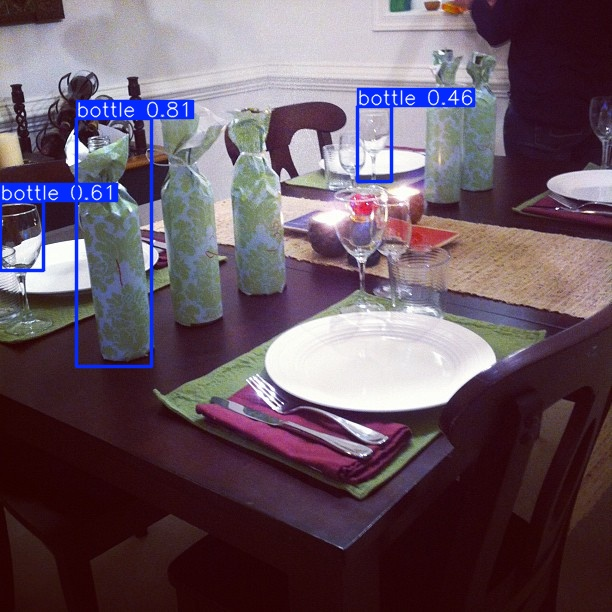

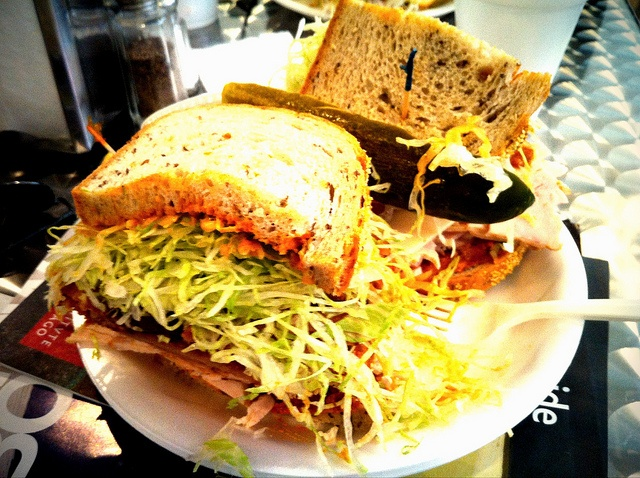

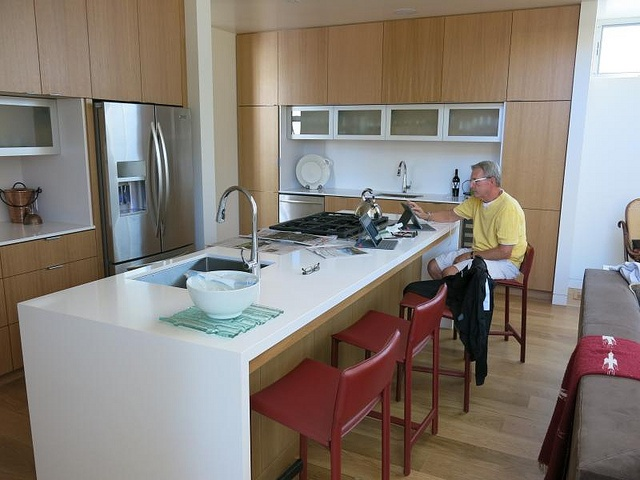

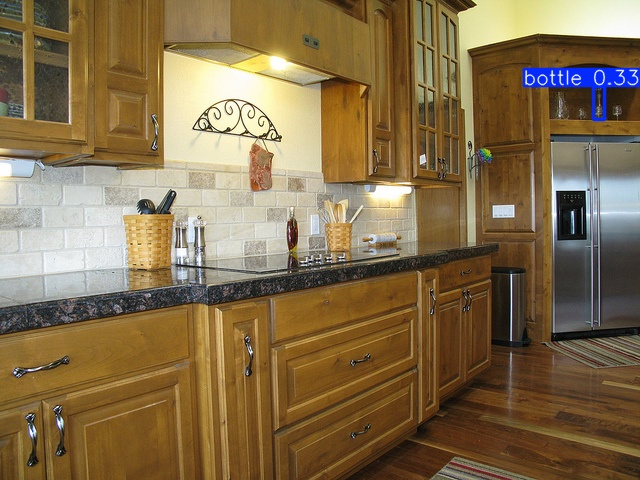

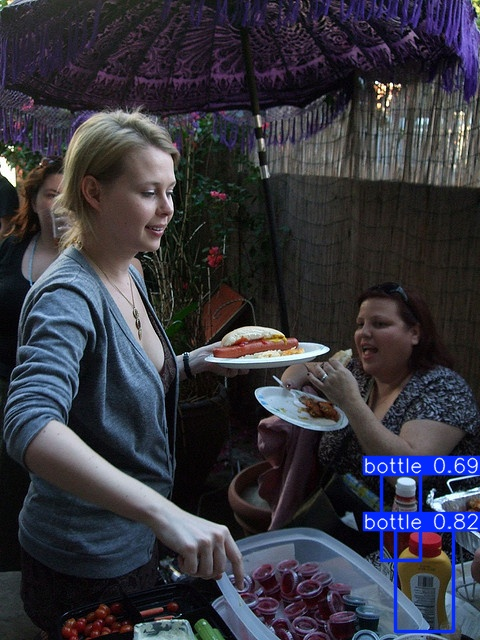

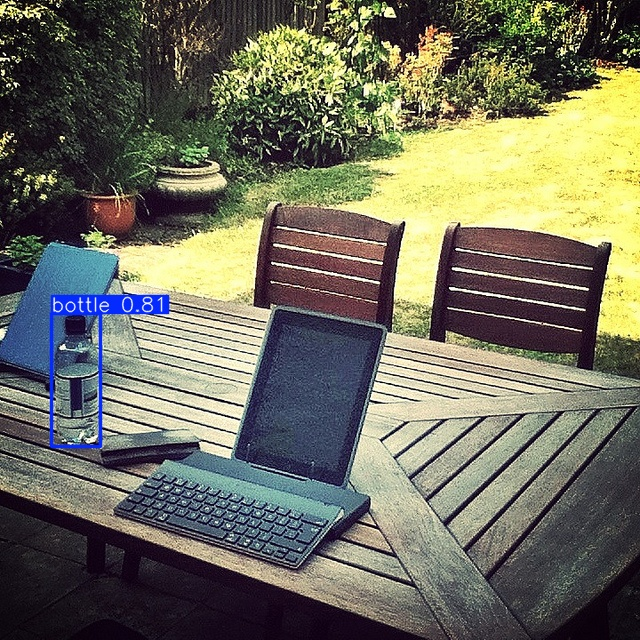

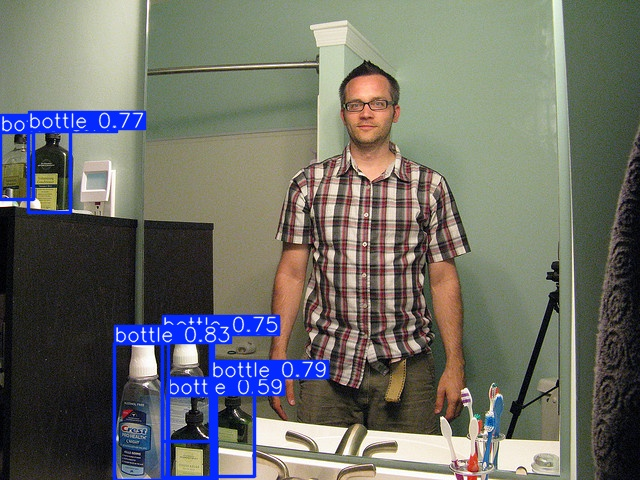

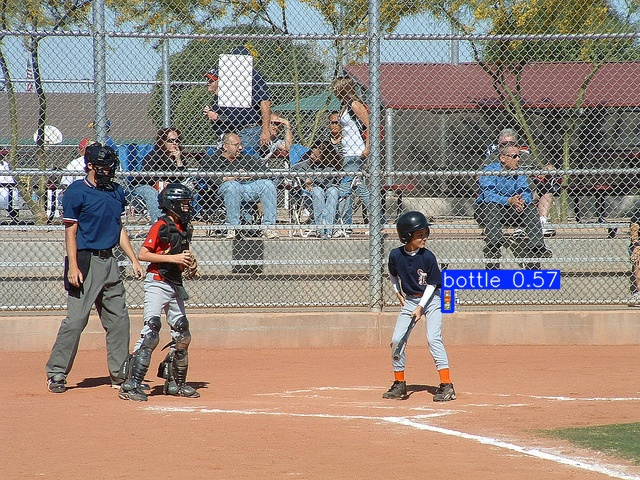

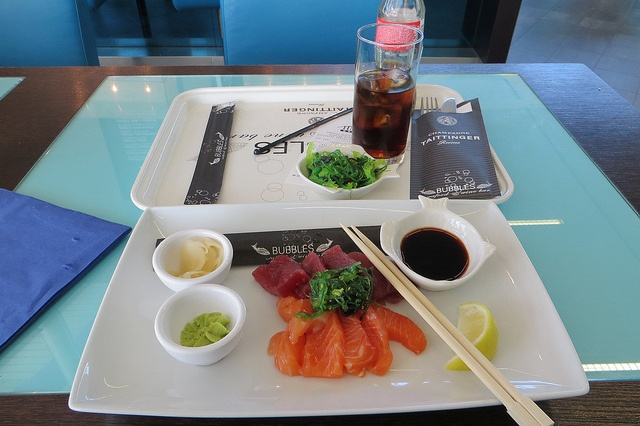

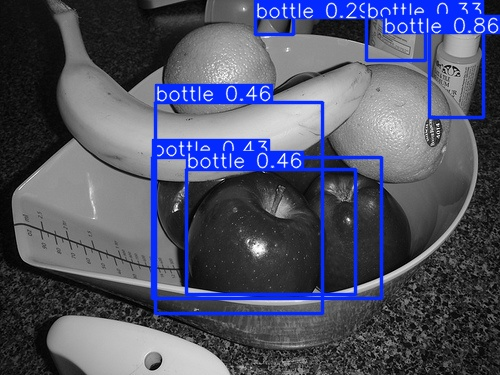

In [7]:
# Display some of the validation results (10 images with label predictions)
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'./runs/detect/predict2/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')

### Inference
Load the trained YOLOv11 model and run its predictions on a test video `../data/candy_data_06JAN25-test/testvid.mp4`, generating a new output video with predictions of object detections stored in `../results/output_video.mp4`.

In [8]:
import glob
import time
import cv2
import numpy as np
from ultralytics import YOLO

# Define variables
model_path = './runs/detect/train17/weights/best.pt'
img_source = f'{data_dir}-test/testvid.mp4'
user_res = '1280x720'
record = True

# Ensure the model path is valid
if (not os.path.exists(model_path)):
    print('ERROR: Model path is invalid or model was not found. Make sure \
        the model filename was entered correctly.')
    sys.exit(0)
else:
    print('Model found')

# Load the model
model = YOLO(model_path, task='detect')
labels = model.names

Model found


In [10]:
# Parse input to see if image source is a file, folder, video, or USB camera
img_ext_list = ['.jpg','.JPG','.jpeg','.JPEG','.png','.PNG','.bmp','.BMP']
vid_ext_list = ['.avi','.mov','.mp4','.mkv','.wmv']
if os.path.isdir(img_source):
    source_type = 'folder'
elif os.path.isfile(img_source):
    _, ext = os.path.splitext(img_source)
    if ext in img_ext_list:
        source_type = 'image'
    elif ext in vid_ext_list:
        source_type = 'video'
    else:
        print(f'File extension {ext} is not supported.')
        sys.exit(0)
elif 'usb' in img_source:
    source_type = 'usb'
    usb_idx = int(img_source[3:])
elif 'picamera' in img_source:
    source_type = 'picamera'
    picam_idx = int(img_source[8:])
else:
    print(f'Input {img_source} is invalid. Please try again.')
    sys.exit(0)
print(source_type)

video


In [11]:
# Parse user-specified display resolution
resize = False
if user_res:
    resize = True
    resW, resH = int(user_res.split('x')[0]), int(user_res.split('x')[1])
print(resW, resH)

1280 720


In [12]:
# Check if recording is valid and set up recording
if record:
    if source_type not in ['video','usb']:
        print('Recording only works for video and camera sources. Please \
            try again.')
        sys.exit(0)
    if not user_res:
        print('Please specify resolution to record video at.')
        sys.exit(0)
    
    # Set up recording
    record_name = '../results/demo1.mp4'
    record_fps = 30
    recorder = cv2.VideoWriter(record_name, cv2.VideoWriter_fourcc(*'mp4v'), \
        record_fps, (resW,resH))

In [13]:
# Load or initialize image source
if source_type == 'image':
    imgs_list = [img_source]
elif source_type == 'folder':
    imgs_list = []
    filelist = glob.glob(img_source + '/*')
    for file in filelist:
        _, file_ext = os.path.splitext(file)
        if file_ext in img_ext_list:
            imgs_list.append(file)
elif source_type == 'video' or source_type == 'usb':
    if source_type == 'video': cap_arg = img_source
    elif source_type == 'usb': cap_arg = usb_idx
    cap = cv2.VideoCapture(cap_arg)

    # Set camera or video resolution if specified by user
    if user_res:
        ret = cap.set(3, resW)
        ret = cap.set(4, resH)
elif source_type == 'picamera':
    from picamera2 import Picamera2
    cap = Picamera2()
    cap.configure(cap.create_video_configuration(main={"format": 'RGB888', \
        "size": (resW, resH)}))
    cap.start()

In [21]:
# Set bounding box colors (using the Tableau 10 color scheme)
bbox_colors = [(164,120,87), (68,148,228), (93,97,209), (178,182,133), (88,159,106), 
              (96,202,231), (159,124,168), (169,162,241), (98,118,150), (172,176,184)]

# Initialize control and status variables
avg_frame_rate = 0
frame_rate_buffer = []
fps_avg_len = 200
img_count = 0

# Define the video codec and create a VideoWriter object
output_path = '../results/output_video.mp4'  # Set your desired output path and filename
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Choose codec (e.g., XVID, MJPG)
fps = 20  # Set frames per second (adjust to your needs)

# Create VideoWriter object
recorder = cv2.VideoWriter(output_path, fourcc, fps, (resW, resH))

# Begin inference loop
while True:
    # Load frame from image source
    t_start = time.perf_counter()
    if source_type == 'image' or source_type == 'folder':
        # If source is image or image folder, load image using its filename
        if img_count >= len(imgs_list):
            print('All images have been processed. Exiting program.')
            sys.exit(0)
        img_filename = imgs_list[img_count]
        frame = cv2.imread(img_filename)
        img_count = img_count + 1
    # If source is a video, load next frame from video file
    elif source_type == 'video':
        ret, frame = cap.read()
        if not ret:
            print('Reached end of the video file. Exiting program.')
            break
    # If source is a USB camera, grab frame from camera
    elif source_type == 'usb': 
        ret, frame = cap.read()
        if (frame is None) or (not ret):
            print('Unable to read frames from the camera. This indicates the \
                camera is disconnected or not working. Exiting program.')
            break
    # If source is a Picamera, grab frames using picamera interface
    elif source_type == 'picamera': 
        frame = cap.capture_array()
        if (frame is None):
            print('Unable to read frames from the Picamera. This indicates \
                the camera is disconnected or not working. Exiting program.')
            break

    # Resize frame to desired display resolution
    if resize == True:
        frame = cv2.resize(frame, (resW, resH))

    # Run inference on frame and extract results
    results = model(frame, verbose=False)
    detections = results[0].boxes

    # Go through each detection and get bbox coords, confidence, and class,
    # and count the number of objects detected
    object_count = 0
    for i in range(len(detections)):
        # Get bounding box coordinates. Ultralytics returns results in
        # Tensor format, which have to be converted to a regular Python array.
        xyxy_tensor = detections[i].xyxy.cpu() # Tensor format in CPU memory
        xyxy = xyxy_tensor.numpy().squeeze() # Convert to Numpy array
        xmin, ymin, xmax, ymax = xyxy.astype(int) # Extract int coords

        # Get bounding box class ID, name, and confidence
        classidx = int(detections[i].cls.item())
        classname = labels[classidx]
        conf = detections[i].conf.item()

        # Draw box if confidence threshold is high enough
        if conf > 0.5:
            color = bbox_colors[classidx % 10]
            cv2.rectangle(frame, (xmin,ymin), (xmax,ymax), color, 2)

            # Draw label with class name and confidence
            label = f'{classname}: {int(conf*100)}%'
            labelSize, baseLine = cv2.getTextSize(label, \
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10)
            
            # Draw label background
            cv2.rectangle(frame, (xmin, label_ymin-labelSize[1]-10), \
                (xmin+labelSize[0], label_ymin+baseLine-10), color, \
                    cv2.FILLED) # Draw white box to put label text in
            cv2.putText(frame, label, (xmin, label_ymin-7), \
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1) # Draw label text

            # Basic example: count the number of objects in the image
            object_count = object_count + 1

    # Calculate and draw framerate (if using video, USB, or Picamera source)
    if source_type == 'video' or source_type == 'usb' or source_type == 'picamera':
        cv2.putText(frame, f'FPS: {avg_frame_rate:0.2f}', (10,20), \
            cv2.FONT_HERSHEY_SIMPLEX, .7, (0,255,255), 2) # Draw framerate
    
    # Display detection results
    # cv2.putText(frame, f'Number of objects: {object_count}', (10,40), \
    #     cv2.FONT_HERSHEY_SIMPLEX, .7, (0,255,255), 2) # Draw number of objects
    # cv2.imshow('YOLO detection results', frame) # Display image
    if record:
        recorder.write(frame)

    # If inferencing on individual images, wait for user keypress before
    # moving to next image. Otherwise, wait 5ms before moving to next frame.
    if source_type == 'image' or source_type == 'folder':
        key = cv2.waitKey()
    elif source_type == 'video' or source_type == 'usb' or source_type == 'picamera':
        key = ""
        # key = cv2.waitKey(5)
    
    # Press 'q' to quit
    if key == ord('q') or key == ord('Q'):
        break
    # Press 's' to pause inference
    elif key == ord('s') or key == ord('S'):
        cv2.waitKey()
    # Press 'p' to save a picture of results on this frame
    elif key == ord('p') or key == ord('P'):
        cv2.imwrite('capture.png',frame)
    
    # Calculate FPS for this frame
    t_stop = time.perf_counter()
    frame_rate_calc = float(1/(t_stop - t_start))

    # Append FPS result to frame_rate_buffer (for finding average FPS
    # over multiple frames)
    if len(frame_rate_buffer) >= fps_avg_len:
        temp = frame_rate_buffer.pop(0)
        frame_rate_buffer.append(frame_rate_calc)
    else:
        frame_rate_buffer.append(frame_rate_calc)

    # Calculate average FPS for past frames
    avg_frame_rate = np.mean(frame_rate_buffer)
    if record:
        recorder.write(frame)

recorder.release()

Reached end of the video file. Exiting program.


In [24]:
# Clean up
print(f'Average pipeline FPS: {avg_frame_rate:.2f}')
if source_type == 'video' or source_type == 'usb':
    cap.release()
elif source_type == 'picamera':
    cap.stop()
if record:
    recorder.release()
# cv2.destroyAllWindows()

Average pipeline FPS: 86.48
